## Notebook to visualize and explore post substorm chorus wave data

@author Riley Troyer
science@rileytroyer.com

In [19]:
# Libraries for notebook
from datetime import datetime
import h5py
import logging
from matplotlib import colormaps
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pickle
from scipy.stats import pearsonr
import scipy.stats as stats
import statsmodels.graphics.gofplots as sm
from sklearn.utils import resample
import sys

# Add root to path
path_root = Path('../../').resolve()
sys.path.append(str(path_root))

# Function to read in PFISR data
from src.features.analysis_functions import create_chorus_selector
from src.features.analysis_functions import create_plotting_data
from src.features.analysis_functions import bootstrap_slope_error

In [2]:
# Read in the h5 data with the data
psd_type = 'integrated'
data_file = h5py.File(f'../../data/processed/analysis-data-{psd_type}.h5')

ubc_b = np.array(data_file['ubc_b'])
lbc_b = np.array(data_file['lbc_b'])
chorus_b = np.array(data_file['chorus_b'])
ubc_e = np.array(data_file['ubc_e'])
lbc_e = np.array(data_file['lbc_e'])
chorus_e = np.array(data_file['chorus_e'])

mlt = np.array(data_file['mlt'])
l = np.array(data_file['l'])
mlat = np.array(data_file['mlat'])
delay = np.array(data_file['delay'])

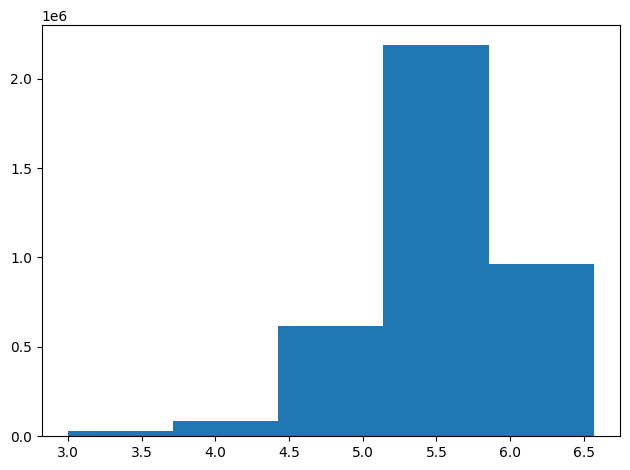

In [3]:
# Histogram of L values
plt.hist(l[l>3], bins=5)
plt.tight_layout()

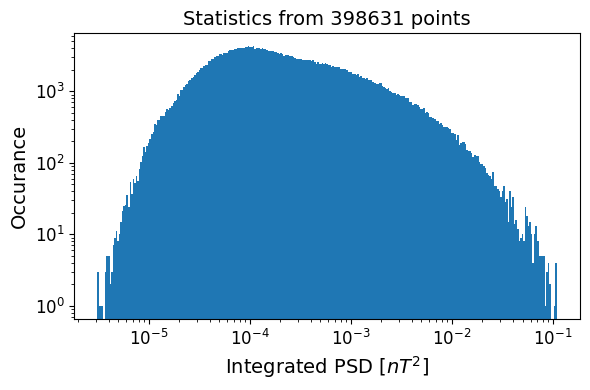

In [4]:
# Histogram of full distribution
start_bin = 0
y = chorus_b[(chorus_b>0) & np.isfinite(chorus_b) & (l>3)]

bins = np.logspace(np.log10(np.nanmin(y)), np.log10(np.nanmax(y)), 300)

# Create the figure
fig, ax = plt.subplots(figsize=(6,4))

# Setup axis
ax.set_title('Statistics from {} points'.format(len(y)), fontsize=14)
ax.set_xlabel(r'Integrated PSD [$nT^2$]', fontsize=14)
ax.set_ylabel('Occurance', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.hist(y, bins=bins)

plt.tight_layout()

#plt.savefig(proj_dir + 'figures/rbsp-figures/all-chorus-distribution.jpg', dpi=150)

In [5]:
# Select the proper data
start_hour = 0
end_hour = 1
low_mlt, high_mlt = 9, 18
low_mlt_exclude = 0
high_mlt_exclude = 0
low_l, high_l = 3.8, 6
low_mlat, high_mlat = 10,20

# Define what the mlt bounds are for plotting, filenames, etc.
if high_mlt_exclude == 0:
    mlt_range_1 = low_mlt
    mlt_range_2 = high_mlt
else:
    mlt_range_1 = high_mlt_exclude
    mlt_range_2 = low_mlt_exclude

# Number of bootstrap iterations
bootstrap_n = 1000

# Selector that applies to all
general_selector = ((mlt >= low_mlt) & (mlt < high_mlt)
                    & ((mlt < low_mlt_exclude) | (mlt >= high_mlt_exclude))
                    & (l >= low_l) & (l < high_l)
                    & (np.abs(mlat) >= low_mlat) & (np.abs(mlat) < high_mlat)
                   )
time_selector = (delay <= end_hour*60*60) & (delay > start_hour*60*60)

# Create selectors for both electric and magnetic fields
selector_dict = {}
selector_dict[0]  = create_chorus_selector(chorus_e, lbc_e, ubc_e, general_selector)
selector_dict[1]  = create_chorus_selector(chorus_b, lbc_b, ubc_b, general_selector)

print(f"Chorus: {len(chorus_b[selector_dict[1]['chorus_selector'] & time_selector])}")
print(f"LBC: {len(lbc_b[selector_dict[1]['lbc_selector'] & time_selector])}")
print(f"UBC: {len(ubc_b[selector_dict[1]['ubc_selector'] & time_selector])}")

print(f"Chorus: {len(chorus_e[selector_dict[0]['chorus_selector'] & time_selector])}")
print(f"LBC: {len(lbc_e[selector_dict[0]['lbc_selector'] & time_selector])}")
print(f"UBC: {len(ubc_e[selector_dict[0]['ubc_selector'] & time_selector])}")

Chorus: 37635
LBC: 37624
UBC: 309
Chorus: 35459
LBC: 35448
UBC: 139


In [6]:
# Specify parameters for statistics
bin_size = 1
method = 'peak'
cutoff = 0

plotting_dict = {}
# Get plotting data for electric fields
plotting_dict[0] = create_plotting_data(delay, chorus_e,
                                        selector_dict[0]['chorus_selector'], 
                                        lbc_e, selector_dict[0]['lbc_selector'],
                                        ubc_e, selector_dict[0]['ubc_selector'],
                                        bin_size, cutoff, method=method)
                                        
# Get plotting data for magnetic fields
plotting_dict[1] = create_plotting_data(delay, chorus_b,
                                        selector_dict[1]['chorus_selector'], 
                                        lbc_b, selector_dict[1]['lbc_selector'],
                                        ubc_b, selector_dict[1]['ubc_selector'],
                                        bin_size, cutoff, method=method)

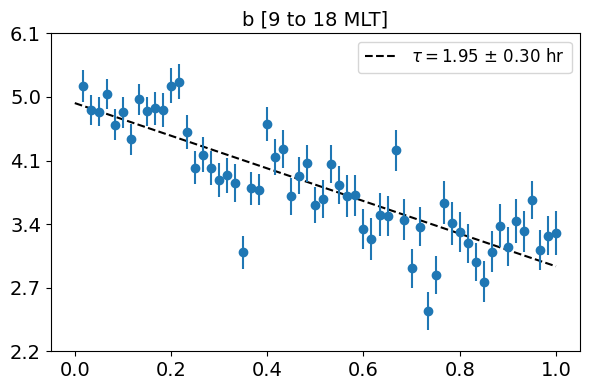

In [10]:
# Plot only the magnetic field

# Create the plot
fig, axs = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)

# Set up titles and axis labels
axs.set_title(f'b [{mlt_range_1} to {mlt_range_2} MLT]', fontsize=14)
#axs.set_title('d', fontsize=14)
#axs.set_xlabel('Hours after start of quiet period', fontsize=14)
# axs.set_ylabel(fr'{low_mlat}$^\circ$ $\leq$ |MLAT| < {high_mlat}$^\circ$'
#                 '\n'
#                 r'Wave Power x $10^{-4}$ $\left[nT^2\right]$', fontsize=14)


# Read in data from dictionary for magnetic field
data = plotting_dict[1]

# Data to plot
avg_x = data['delay_chorus']/3600
avg_y = np.log(data['chorus_bins'])
error_y = (1/data['chorus_bins']) * (data['chorus_bins'] - data['chorus_bins_q1_q3'][0])

# Data to perform linear fit with
x = avg_x[np.isfinite(avg_y) & (avg_x <= end_hour) & (avg_x >= start_hour)]
y = avg_y[np.isfinite(avg_y) & (avg_x <= end_hour)& (avg_x >= start_hour)]
dy = error_y[np.isfinite(avg_y) & (avg_x <= end_hour)& (avg_x >= start_hour)]

# Linear regression
finite_fit_mask = np.isfinite(avg_y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# The fit line
fit_x = np.linspace(start_hour, end_hour, 100)
fit_y = slope*fit_x + intercept

# Calculate error in tau
slope_error = bootstrap_slope_error(x, y, bootstrap_n)
tau_error = (2/(slope)**2)*slope_error

# best_fit is the best fit line
best_fit = slope*x + intercept

# Store in dictionary
fit_dict = {'chorus' : {'slope': slope,
                        'intercept': intercept,
                        'x': x,
                        'y': y}}

# Best fit plot
label = (fr'$\tau = ${(-1/slope):0.2f} $\pm$ {tau_error:0.2f} hr')
        #'\n'
        #fr'       $r^2 = ${r_value**2:0.2f}')
#label = (fr'$\tau = ${-1/slope:0.2f} hr')
axs.plot(fit_x, fit_y, color='black', linestyle='--',
            label=label)

# Plot data
#axs.scatter(x, y, color='C0')
axs.errorbar(x, y, yerr=dy, fmt="o", color='C0')

# Setup the ticks
yticks = axs.get_yticks()
axs.set_yticks(ticks=yticks)
axs.set_yticklabels(labels=[rf'{n/1e-4:0.1f}' for n in np.exp(yticks)])
axs.tick_params(axis='both', labelsize=14)

axs.legend(fontsize=12, loc='upper right')

    
save_filename = (f'chorus-decay-intpsd-'
                 f'{mlt_range_1}to{mlt_range_2}mlt'
                 f'-{low_mlat}to{high_mlat}mlat.jpg')
#save_filename = f'chorus-decay-intpsd-21to3mlt.jpg'
#plt.savefig(proj_dir + 'figures/rbsp-figures/b-mlt-mlat-plot-intpsd/' + save_filename, dpi=300)


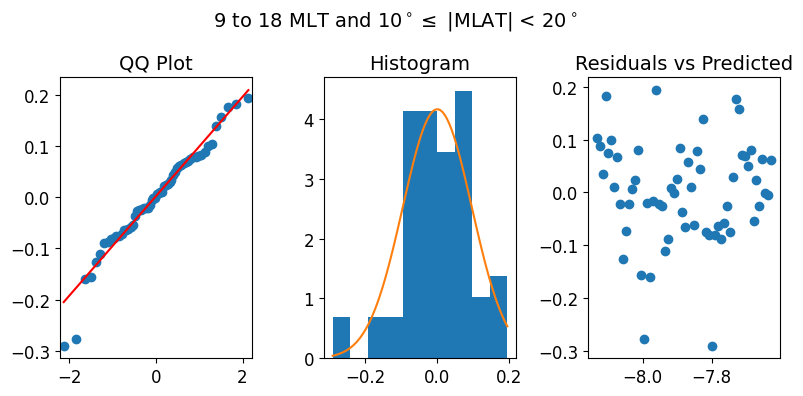

In [11]:
# Plot normal probability plot
# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(8, 4), tight_layout=True)

fig.suptitle(fr'{mlt_range_1} to {mlt_range_2} MLT and {low_mlat}$^\circ \leq$ |MLAT| < {high_mlat}$^\circ$', fontsize=14)

# Set up the titles and labels
axs[0].set_title('QQ Plot', fontsize=14)
axs[0].tick_params(axis='both', labelsize=12)

axs[1].set_title('Histogram', fontsize=14)
axs[1].tick_params(axis='both', labelsize=12)

axs[2].set_title('Residuals vs Predicted', fontsize=14)
axs[2].tick_params(axis='both', labelsize=12)

# Plot the QQ plot
# Calculate residuals by first getting predicted values
predicted_values = fit_dict['chorus']['slope']*fit_dict['chorus']['x'] + fit_dict['chorus']['intercept']
residuals = fit_dict['chorus']['y'] - predicted_values

sm.ProbPlot(residuals).qqplot(line='q', ax=axs[0])
axs[0].set_ylabel(None)
axs[0].set_xlabel(None)

# Plot the histogram
# Perform fit
params = stats.norm.fit(residuals)

axs[1].hist(residuals, bins=10, density=True)
axs[1].plot(np.linspace(np.min(residuals), np.max(residuals), 100),
           stats.norm.pdf(np.linspace(np.min(residuals),
           np.max(residuals), 100), *params))

# Plot the residuals scatter
axs[2].scatter(predicted_values, residuals)

plt.tight_layout()

save_filename = (f'regression-quality-'
                 f'{mlt_range_1}to{mlt_range_2}mlt'
                 f'-{low_mlat}to{high_mlat}mlat.jpg')
#plt.savefig(proj_dir + 'figures/rbsp-figures/error-plots/' + save_filename, dpi=300)

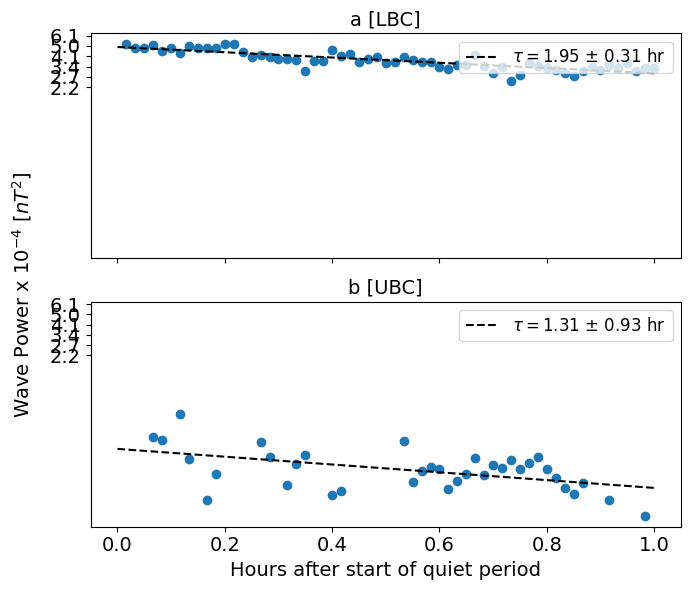

In [13]:
# Create the plot
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True, sharey=True,
                        tight_layout=True)

# Set up titles and axis labels
#plt.suptitle(fr'{low_mlt}-{high_mlt} MLT, {low_l} <L< {high_l}', fontsize=16)

axs[1].set_xlabel('Hours after start of quiet period', fontsize=14)

fig.supylabel(r'Wave Power x $10^{-4}$ $\left[nT^2\right]$', fontsize=14)

# Add subfigure titles
#axs.set_title(f'{mlt_range_1} to {mlt_range_2} MLT')
axs[0].set_title('a [LBC]', fontsize=14)
axs[1].set_title('b [UBC]', fontsize=14)
  
# Read in data from dictionary for magnetic field
data = plotting_dict[1]

fit_dict = {}

# Data to plot
for n, chorus_type in enumerate(['lbc', 'ubc']):

        avg_x = data['delay_' + chorus_type]/3600
        avg_y = np.log(data[chorus_type + '_bins'])

        # Data to perform linear fit with
        x = avg_x[np.isfinite(avg_y) & (avg_x <= end_hour)]
        y = avg_y[np.isfinite(avg_y) & (avg_x <= end_hour)]

        # Linear regression
        finite_fit_mask = np.isfinite(avg_y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # The fit line
        fit_x = np.linspace(0, end_hour, 100)
        fit_y = slope*fit_x + intercept

        # Calculate error in tau
        slope_error = bootstrap_slope_error(x, y, bootstrap_n)
        tau_error = (2/(slope)**2)*slope_error

        # best_fit is the best fit line
        best_fit = slope*x + intercept

        # Write values to dictionary
        fit_dict[chorus_type] = {'slope': slope,
                                 'intercept': intercept,
                                 'x':x,
                                 'y':y}

        # Best fit plot
        label = (fr'$\tau = ${(-1/slope):0.2f} $\pm$ {tau_error:0.2f} hr')
                #'\n'
                #fr'       $r^2 = ${r_value**2:0.2f}')
        #label = (fr'$\tau = ${-1/slope:0.2f} hr')
        axs[n].plot(fit_x, fit_y, color='black', linestyle='--',
                label=label)

        # Plot data
        axs[n].scatter(x, y, color='C0')

        # Setup the ticks
        yticks = axs[n].get_yticks()
        axs[n].set_yticks(ticks=yticks)
        axs[n].set_yticklabels(labels=[rf'{i/1e-4:0.1f}' for i in np.exp(yticks)])
        axs[n].tick_params(axis='both', labelsize=14)

        axs[n].legend(fontsize=12, loc='upper right')



    
#save_filename = f'lbc-ubc-decay-intpsd-{low_mlt}to{high_mlt}mlt-onlyb.jpg'
save_filename = (f'lbc-ubc-decay-intpsd-'
                 f'{mlt_range_1}to{mlt_range_2}mlt'
                 f'-{low_mlat}to{high_mlat}mlat-onlyb.jpg')
#save_filename = f'lbc-ubc-decay-intpsd-21to3mlt.jpg'
#plt.savefig(proj_dir + 'figures/rbsp-figures/' + save_filename, dpi=300)

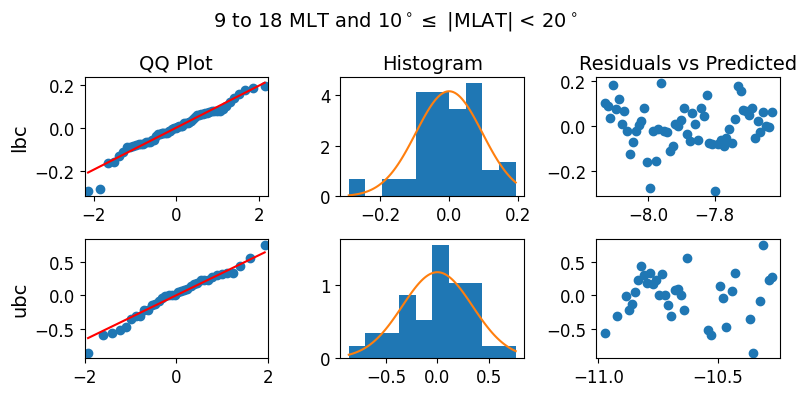

In [15]:
# Plot normal probability plot
# Create the plot
fig, axs = plt.subplots(2, 3, figsize=(8, 4), tight_layout=True)

fig.suptitle(fr'{mlt_range_1} to {mlt_range_2} MLT and {low_mlat}$^\circ \leq$ |MLAT| < {high_mlat}$^\circ$', fontsize=14)

for n, chorus_type in enumerate(['lbc', 'ubc']):

        # Set up the titles and labels
        if n==0:
                axs[n, 0].set_title('QQ Plot', fontsize=14)
                axs[n, 1].set_title('Histogram', fontsize=14)
                axs[n, 2].set_title('Residuals vs Predicted', fontsize=14)

        axs[n, 0].tick_params(axis='both', labelsize=12)
        axs[n, 1].tick_params(axis='both', labelsize=12)
        axs[n, 2].tick_params(axis='both', labelsize=12)

        # Plot the QQ plot
        # Calculate residuals by first getting predicted values
        predicted_values = fit_dict[chorus_type]['slope']*fit_dict[chorus_type]['x'] + fit_dict[chorus_type]['intercept']

        # Calculate and plot histogram residuals
        residuals = fit_dict[chorus_type]['y'] - predicted_values
        sm.ProbPlot(residuals).qqplot(line='q', ax=axs[n, 0])
        axs[n, 0].set_ylabel(chorus_type, fontsize=14)
        axs[n, 0].set_xlabel(None)

        # Plot the histogram

        # Perform fit
        params = stats.norm.fit(residuals)

        axs[n, 1].hist(residuals, bins=10, density=True)
        axs[n, 1].plot(np.linspace(np.min(residuals), np.max(residuals), 100),
                stats.norm.pdf(np.linspace(np.min(residuals),
                np.max(residuals), 100), *params))

        # Plot the residuals scatter
        axs[n, 2].scatter(predicted_values, residuals)

save_filename = (f'lbc-ubc-fit-quality-'
                 f'{mlt_range_1}to{mlt_range_2}mlt'
                 f'-{low_mlat}to{high_mlat}mlat-onlyb.jpg')
#plt.savefig(proj_dir + 'figures/rbsp-figures/error-plots/' + save_filename, dpi=300)

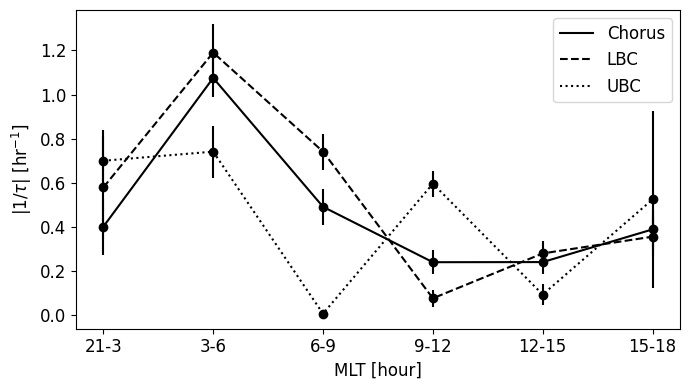

In [16]:
mlt = ['21-3', '3-6', '6-9', '9-12', '12-15', '15-18']
x = [0, 1, 2, 3, 4, 5]

decay_plot_dict = {0: {'b_tau' : np.array([2.50, 0.93, 2.04, 4.19, 4.18, 2.58]),
                       'b_error' : np.array([1.59, 0.15, 0.69, 1.89, 1.82, 1.2]),
                       'e_tau' : np.array([0.44, 1.89, 2.44, 5.43, 59.39, 1.22]),
                       'e_error' : np.array([0.13, 0.74, 0.92, 6.69, 59.39, 0.32]),
                       'label' : 'Chorus',
                       'line': 'solid'},
                   1: {'b_tau' : np.array([1.73, 0.84, 1.35, 13.38, 3.59, 2.82]),
                       'b_error' : np.array([1.41, 0.18, 0.3, 13.38, 1.45, 1.40]),
                       'e_tau' : np.array([0.64, 1.73, 2.42, 2.69, 35.59, 1.16]),
                       'e_error' : np.array([0.43, 1.04, 1.31, 2.20, 35.59, 0.25]),
                       'label' : 'LBC',
                       'line': 'dashed'},
                   2: {'b_tau' : np.array([1.43, 1.35, 208, 1.68, 10.89, 1.91]),
                       'b_error' : np.array([0.57, 0.43, 208, 0.33, 10.89, 2.94]),
                       'e_tau' : np.array([0.52, 2.05, 34.71, 36.9, 40.94, 1.73]),
                       'e_error' : np.array([0.21, 1.14, 34.71, 36.9, 40.94, 2.27]),
                       'label' : 'UBC',
                       'line' : 'dotted'}
                  }

# decay_plot_dict = {0: {'b_tau' : np.array([2.10, 0.87, 2.13, 3.72, 5.90, 2.71]),
#                        'b_error' : np.array([0.43, 0.05, 0.19, 0.68, 1.49, 0.35]),
#                        'e_tau' : np.array([0.73, 2.90, 2.61, 4.08, 100, 1.35]),
#                        'e_error' : np.array([0.07, 0.69, 0.35, 0.87, 33, 0.14]),
#                        'label' : 'Chorus',
#                        'line': 'solid'},
#                    1: {'b_tau' : np.array([1.90, 0.75, 1.74, 4.27, 5.27, 2.95]),
#                        'b_error' : np.array([0.43, 0.04, 0.15, 0.97, 1.22, 0.42]),
#                        'e_tau' : np.array([1, 5.16, 2.87, 2.63, 100, 1.27]),
#                        'e_error' : np.array([0.20, 3.09, 0.51, 0.42, 20, 0.13]),
#                        'label' : 'LBC',
#                        'line': 'dashed'},
#                    2: {'b_tau' : np.array([2.15, 1.45, 16.57, 2.35, 4.79, 1.39]),
#                        'b_error' : np.array([0.57, 0.18, 15.28, 0.38, 1.63, 0.45]),
#                        'e_tau' : np.array([0.97, 2.97, 7.53, 100, 4.72, 3.75]),
#                        'e_error' : np.array([0.15, 0.80, 3.20, 30, 1.81, 3.88]),
#                        'label' : 'UBC',
#                        'line' : 'dotted'}
#                   }

# Plot decay rates as a function of MLT
# mlt = ['21-24', '0-3', '3-6', '6-9', '9-12']
# x = [0, 1, 2, 3, 4]

# b_chorus_tau = np.array([0.98, 1.89, 0.98, 6.87, 4.62])
# b_chorus_terr = np.array([0.18, 0.29, 0.07, 3.49, 1.77])
# e_chorus_tau = np.array([0.62, 1.01, 1.13, 4.12, 4.79])
# e_chorus_terr = np.array([0.09, 0.09, 0.11, 1.37, 2.30])



# Setup the figure
fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharex=True,
                        tight_layout=True)

axs.set_xlabel('MLT [hour]', fontsize=12)
axs.set_ylabel(r'|1/$\tau$| [hr$^{-1}$]', fontsize=12)

axs.set_xticks(ticks=x, labels=mlt)
axs.tick_params(axis='both', labelsize=12)

for n in range(3):
    
    # Read in data
    b_tau = decay_plot_dict[n]['b_tau']
    b_terr = decay_plot_dict[n]['b_error']
    
    # Convert from tau to slope
    b_slope = 1/b_tau
    b_serr = b_terr/(2*b_tau**2)

    # The actual data plotted
    axs.scatter(x, b_slope, color='k')
    axs.plot(x, b_slope, linestyle=decay_plot_dict[n]['line'],
                color='k', label=decay_plot_dict[n]['label'])
    axs.errorbar(x, b_slope, fmt='none', yerr=b_serr, color='k')


axs.legend(fontsize=12, loc='upper right')

plt.tight_layout()

save_filename = f'decay-rate-vs-mlt-onlyb.jpg'
#plt.savefig(proj_dir + 'figures/rbsp-figures/' + save_filename, dpi=300)

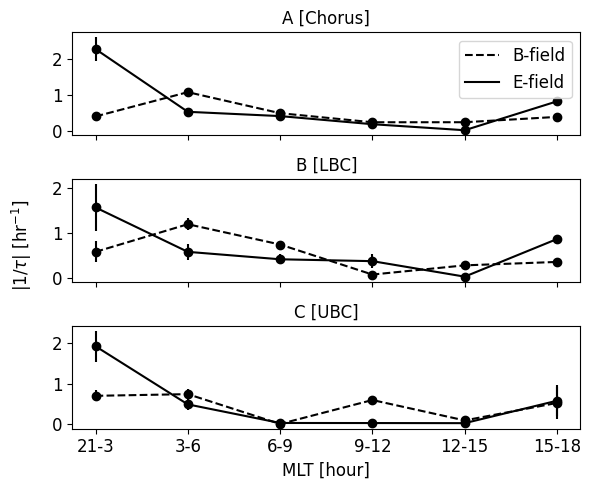

In [17]:
# Plot decay rates as a function of MLT

# Setup the figure
fig, axs = plt.subplots(3, 1, figsize=(6, 5), sharex=True,
                        constrained_layout=False, tight_layout=True)

axs[2].set_xlabel('MLT [hour]', fontsize=12)
fig.supylabel(r'|1/$\tau$| [hr$^{-1}$]', fontsize=12)

# Set subfigure titles
axs[0].set_title(f"A [Chorus]")
axs[1].set_title(f"B [LBC]")
axs[2].set_title(f"C [UBC]")

for n in range(len(axs)):
    
    # Read in data
    b_tau = decay_plot_dict[n]['b_tau']
    b_terr = decay_plot_dict[n]['b_error']
    e_tau = decay_plot_dict[n]['e_tau']
    e_terr = decay_plot_dict[n]['e_error'] 
    
    # Convert from tau to slope
    b_slope = 1/b_tau
    b_serr = b_terr/(2*b_tau**2)
    e_slope = 1/e_tau
    e_serr = e_terr/(2*e_tau**2)
    
    
    # Axis and labels
    #axs[n].set_title(f"{decay_plot_dict[n]['label']}")
    #axs[n].set_ylabel(r'|1/$\tau$|', fontsize=12)
    axs[n].set_xticks(ticks=x, labels=mlt)
    axs[n].tick_params(axis='both', labelsize=12)

    # The actual data plotted
    axs[n].scatter(x, b_slope, color='k')
    axs[n].plot(x, b_slope, linestyle='dashed',
                color='k', label=f'B-field')
    axs[n].errorbar(x, b_slope, fmt='none', yerr=b_serr, color='k')
    axs[n].scatter(x, e_slope, color='k')
    axs[n].plot(x, e_slope, linestyle='solid',
                color='k', label=f'E-field')
    axs[n].errorbar(x, e_slope, fmt='none', yerr=e_serr, color='k')

    # Legend
    if n == 0:
        axs[n].legend(fontsize=12, loc='upper right')

plt.tight_layout()

save_filename = f'decay-rate-vs-mlt.jpg'
#plt.savefig(proj_dir + 'figures/rbsp-figures/' + save_filename, dpi=300)

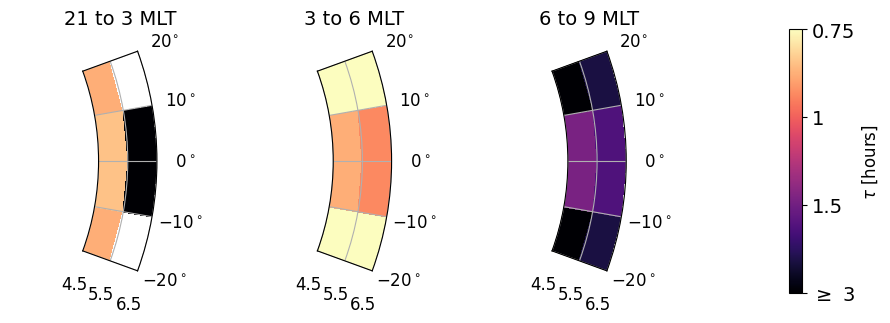

In [20]:
# Data for polar plot of L and MLAT
l_plot = np.array([4.5, 5.5, 6.5])
mlat_plot = np.array([360-20, 360-10, 0, 10, 20])*(np.pi/180)

# Create mesh to plot
l_mesh, mlat_mesh = np.meshgrid(l_plot, mlat_plot)

b_tau_midnight = np.array([[0.86, np.nan],
                           [0.83, 8.67],
                           [0.83, 8.67], 
                           [0.86, np.nan]
                 ])

b_tau_dawn = np.array([[0.71, 0.68],
                       [0.86, 0.92],
                       [0.86, 0.92],
                       [0.71, 0.68]
             ])

b_tau_morning = np.array([[7.25, 2.21],
                          [1.46, 1.72],
                          [1.46, 1.72],
                          [7.25, 2.21]
                ])

tau_plotting_dict = {0 : {'label' : '21 to 3 MLT',
                        'data' : b_tau_midnight},
                 1 : {'label' : '3 to 6 MLT',
                        'data' : b_tau_dawn}, 
                 2 : {'label' : '6 to 9 MLT',
                        'data' : b_tau_morning},
                }

# Modify colormap, so nan values are white
current_cmap = colormaps['magma'].copy()
current_cmap.set_bad(color='white')

# Create plot
fig, axs = plt.subplots(1, 4, figsize=(9,3.5),
                        subplot_kw={'projection': 'polar'},
                        gridspec_kw={'width_ratios': [1, 1, 1, 0.4]})

for n in range(len(axs)-1):
    
    axs[n].set_rorigin(-4.5)
    axs[n].set_thetalim((-20)*(np.pi/180), 20*(np.pi/180))

    axs[n].set_title(tau_plotting_dict[n]['label'], fontsize=14)
    
    axs[n].set_rticks(ticks=[4.5, 5.5, 6.5], labels=[4.5, 5.5, 6.5])
    axs[n].set_xticks(ticks=np.array([-20, -10, 0, 10, 20])*(np.pi/180),
                  labels=[r'$-20^\circ$', r'$-10^\circ$',
                          r'$0^\circ$', r'$10^\circ$', r'$20^{\circ}$'])

    axs[n].tick_params(axis='y', which='major', pad=15, labelsize=12)
    axs[n].tick_params(axis='x', which='major', pad=10 , labelsize=12)

    axs[n].grid(False)

    tau_plot = axs[n].pcolormesh(mlat_mesh, l_mesh, 1/tau_plotting_dict[n]['data'], 
                                 shading='flat', cmap=current_cmap,
                                 vmin=1/3, vmax=1/0.75)

    axs[n].grid(True)
    
    #axs[n].set_aspect(10)

axs[3].axis('off')
tau_cbar = fig.colorbar(tau_plot, ax=axs[3],
                        ticks=[1/3, 2/3, 1, 4/3, 5/3, 2])
tau_cbar.ax.set_yticklabels([r'$\geq$ 3', '1.5', '1', '0.75', '0.6', r'$\leq$ 0.5'])
tau_cbar.set_label(r'$\tau$ [hours]', fontsize=12)
tau_cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

save_filename = f'decay-rate-vs-location.jpg'
#plt.savefig(proj_dir + 'figures/rbsp-figures/' + save_filename, dpi=300)

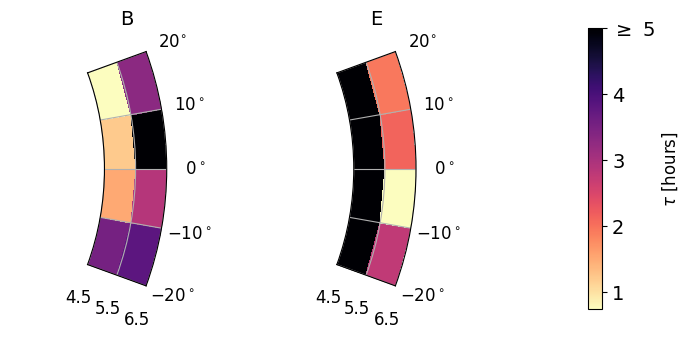

In [21]:
# Data for polar plot of L and MLAT
l_plot = np.array([4.5, 5.5, 6.5])
mlat_plot = np.array([360-20, 360-10, 0, 10, 20])*(np.pi/180)

# Create mesh to plot
l_mesh, mlat_mesh = np.meshgrid(l_plot, mlat_plot)

b_tau_all = np.array([[2.95, 3.13],
                      [1.56, 2.5],
                      [1.36, 3.95], 
                      [1.03, 2.79]
                 ])
e_tau_all = np.array([[5, 2.76],
                      [5, 0.74],
                      [5, 2.13], 
                      [5, 1.94]
                 ])

tau_plotting_dict = {0 : {'label' : 'B',
                        'data' : b_tau_all},
                     1 : {'label' : 'E',
                          'data' : e_tau_all}}

# Modify colormap, so nan values are white
current_cmap = colormaps['magma_r'].copy()
current_cmap.set_bad(color='white')

# Create plot
fig, axs = plt.subplots(1, 3, figsize=(7,3.5),
                        subplot_kw={'projection': 'polar'},
                        gridspec_kw={'width_ratios': [1, 1, 0.4]})

for n in range(len(axs)-1):
    
    axs[n].set_rorigin(-4.5)
    axs[n].set_thetalim((-20)*(np.pi/180), 20*(np.pi/180))

    axs[n].set_title(tau_plotting_dict[n]['label'], fontsize=14)
    
    axs[n].set_rticks(ticks=[4.5, 5.5, 6.5], labels=[4.5, 5.5, 6.5])
    axs[n].set_xticks(ticks=np.array([-20, -10, 0, 10, 20])*(np.pi/180),
                  labels=[r'$-20^\circ$', r'$-10^\circ$',
                          r'$0^\circ$', r'$10^\circ$', r'$20^{\circ}$'])

    axs[n].tick_params(axis='y', which='major', pad=15, labelsize=12)
    axs[n].tick_params(axis='x', which='major', pad=10 , labelsize=12)

    axs[n].grid(False)

    tau_plot = axs[n].pcolormesh(mlat_mesh, l_mesh, tau_plotting_dict[n]['data'], 
                                 shading='flat', cmap=current_cmap)

    axs[n].grid(True)
    
    #axs[n].set_aspect(10)

axs[2].axis('off')
tau_cbar = fig.colorbar(tau_plot, ax=axs[2],
                        ticks=[1, 2, 3, 4, 5])
tau_cbar.ax.set_yticklabels(['1', '2', '3', '4', r'$\geq$ 5'])
tau_cbar.set_label(r'$\tau$ [hours]', fontsize=12)
tau_cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

save_filename = f'decay-rate-vs-location-v2.jpg'
#plt.savefig(proj_dir + 'figures/rbsp-figures/' + save_filename, dpi=300)